In [1]:
from pathlib import Path
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import numpy as np

In [17]:
xray_stat_dfs, rmsd_stat_dfs = list(), list()

target = "3ca7"
job_name = "100_natives_4x"

xray_dir = Path(Path.home(), "Documents/xray")
log_stats_dir = Path(xray_dir, "sample_bench/data", target)

for i in range(10):
    xray_stat_df = pd.read_csv(Path(log_stats_dir, job_name, "xray_volume_bench_{}.csv".format(i)), index_col=0)
    rmsd_stat_df = pd.read_csv(Path(log_stats_dir, job_name, "rmsd_volume_bench_{}.csv".format(i)), index_col=0)

    xray_stat_dfs.append(xray_stat_df)
    rmsd_stat_dfs.append(rmsd_stat_df)

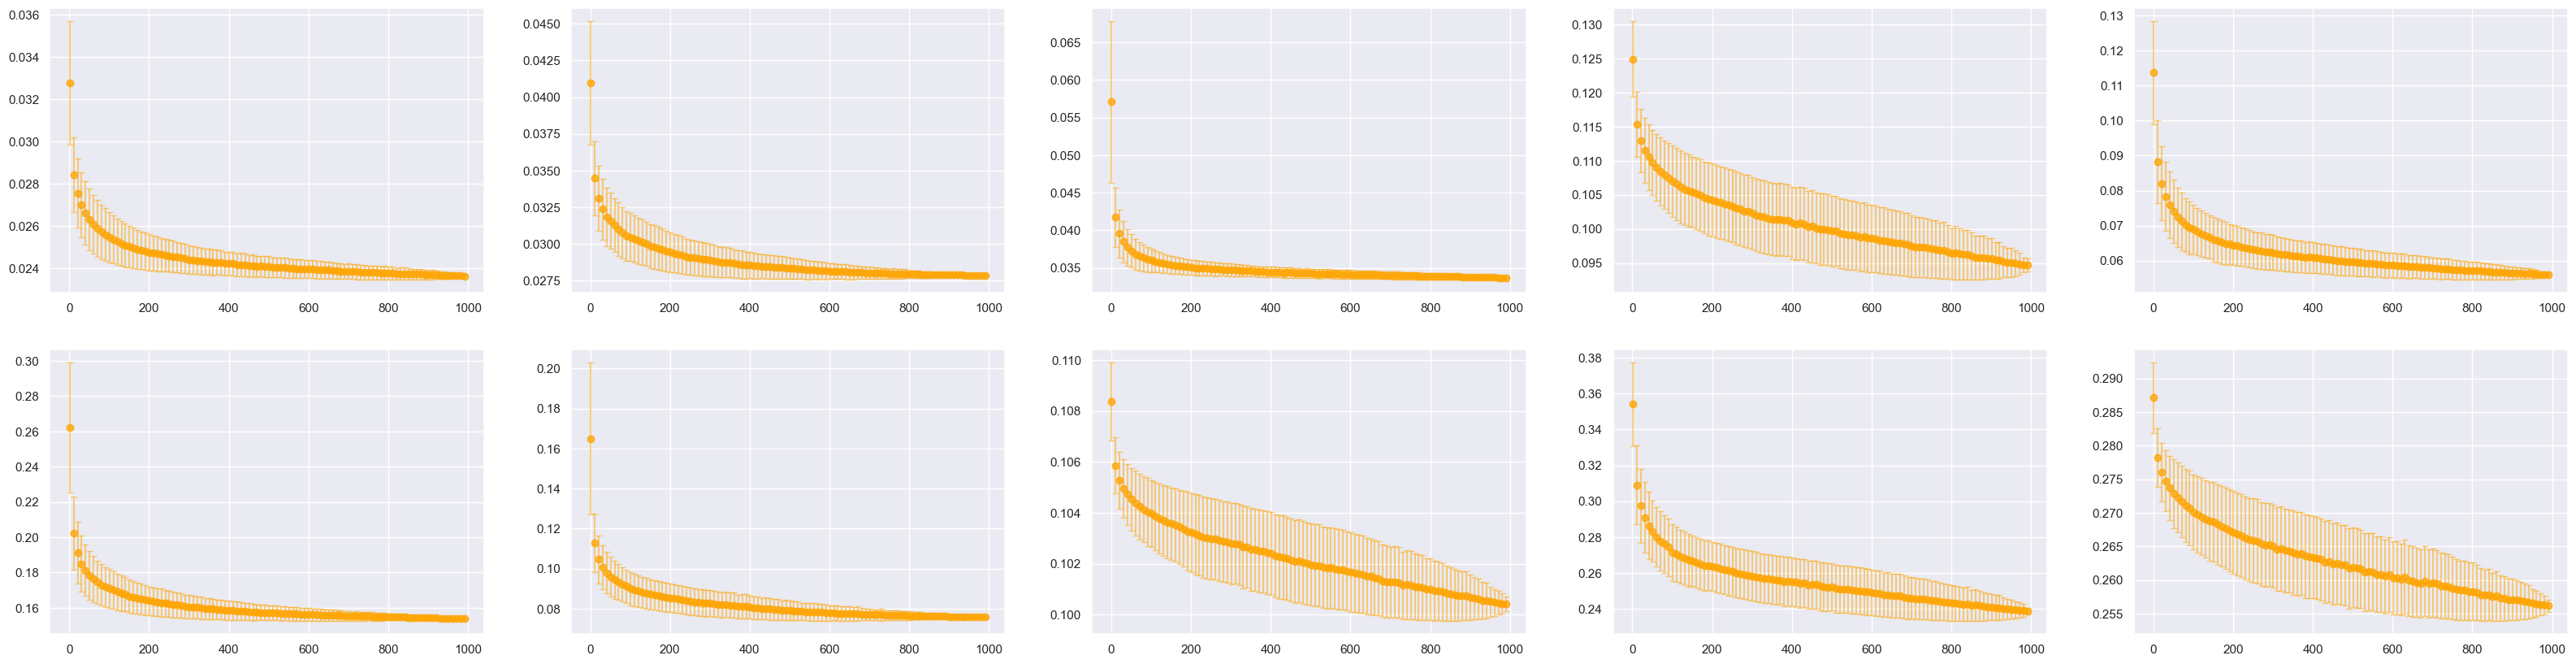

In [25]:
fig, axs = plt.subplots(2, 5, figsize=(40,10))

colors = list()
colors.append(mcolors.CSS4_COLORS["dodgerblue"])
colors.append(mcolors.CSS4_COLORS["orange"])
colors.append(mcolors.CSS4_COLORS["orangered"])

alpha = .5
space = 10

x = xray_stat_df.index[::space]

for i in range(10):
    # y1 = xray_stat_dfs[i]["xray_0_mean"][::space]
    # std1 = xray_stat_dfs[i]["xray_0_std"][::space]

    # y2 = xray_stat_dfs[i]["rmsd_avg_mean"][::space]
    # std2 = xray_stat_dfs[i]["rmsd_avg_std"][::space]

    # ax1 = axs[i//5][i%5]
    # ax1.scatter(x, y1, c=colors[0], alpha=alpha)
    # ax1.errorbar(x, y1, std1, linestyle='None', marker='o', capsize=3, c=colors[0], alpha=alpha)

    # ax2 = ax1.twinx()
    # ax2.scatter(x, y2, c=colors[1], alpha=alpha)
    # ax2.errorbar(x, y2, std2, linestyle='None', marker='o', capsize=3, c=colors[1], alpha=alpha)

    y3 = rmsd_stat_dfs[i]["rmsd_avg_mean"][::space]
    std3 = rmsd_stat_dfs[i]["rmsd_avg_std"][::space]

    ax3 = axs[i//5][i%5]
    ax3.scatter(x, y3, c=colors[1], alpha=alpha)
    ax3.errorbar(x, y3, std3, linestyle='None', marker='o', capsize=3, c=colors[1], alpha=alpha)

plt.savefig(Path(Path.home(), "Desktop/sample_volume_benchmark.png"))


